# Chapter 16: Models with several factors

Load the packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from scipy import stats

## Two factors with no replication

Load in the data

In [2]:
composite = pd.read_csv("data/composite.csv", index_col=0)
composite

,strength,laser,tape
1,25.66,40W,slow
2,29.15,50W,slow
3,35.73,60W,slow
4,28.00,40W,medium
5,35.09,50W,medium
6,39.56,60W,medium
7,20.65,40W,fast
8,29.79,50W,fast
9,35.66,60W,fast


Create the interaction plots:

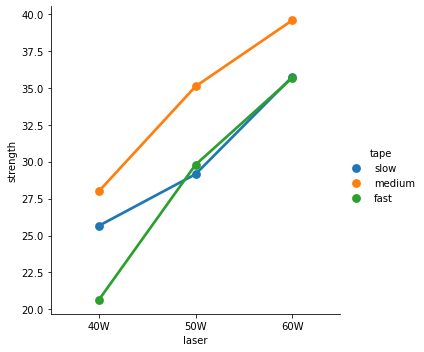

In [3]:
sns.catplot(x="laser", y="strength", hue="tape", data=composite, kind="point")

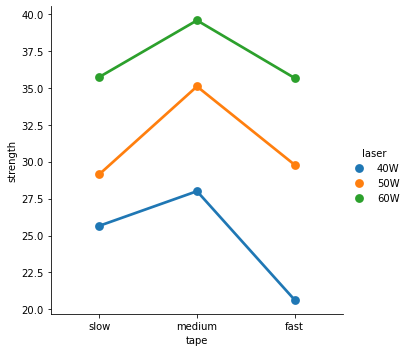

In [4]:
sns.catplot(x="tape", y="strength", hue="laser", data=composite, kind="point")

Fit a saturated model. Don't show the error messages (get complaints about small datasets)

In [5]:
%%capture --no-display
lmod = smf.ols("strength ~ tape * laser", composite).fit()
lmod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               strength   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 23 Jun 2020   Prob (F-statistic):                nan
Time:                        17:12:26   Log-Likelihood:                 274.42
No. Observations:                   9   AIC:                            -530.8
Df Residuals:                       0   BIC:                            -529.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      20.6500        inf          0        nan         nan         nan
tape[T.medium]                  7.3500        inf          0        nan         nan         nan
tape[T.slow]                    5.0100        inf          0        nan         nan         nan
laser[T.50W]                    9.1400        inf          0        nan         nan         nan
laser[T.60W]                   15.0100        inf          0        nan         nan         nan
tape[T.medium]:laser[T.50W]    -2.0500        inf         -0        nan         nan         nan
tape[T.slow]:laser[T.50W]      -5.6500        inf         -0        nan         nan         nan
tape[T.medium]:laser[T.60W]    -3.4500        inf         -0        nan         nan         nan
tape[T.slow]:laser[T.60W]      -4.9400        inf         -0        nan         nan         nan
==============================================================================
Omnibus:                        4.500   Durbin-Watson:                   0.628
Prob(Omnibus):                  0.105   Jarque-Bera (JB):                2.010
Skew:                           1.157   Prob(JB):                        0.366
Kurtosis:                       2.925   Cond. No.                         13.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Fit main effects only model:

In [6]:
lmod = smf.ols("strength ~ tape + laser", composite).fit()
lmod.params

Intercept         22.437778
tape[T.medium]     5.516667
tape[T.slow]       1.480000
laser[T.50W]       6.573333
laser[T.60W]      12.213333
dtype: float64

In [7]:
lasercoefs = np.tile([0, 6.57, 12.21],3)
lasercoefs

array([ 0.  ,  6.57, 12.21,  0.  ,  6.57, 12.21,  0.  ,  6.57, 12.21])

In [8]:
tapecoefs = np.repeat([1.48, 5.52, 0], 3)
tapecoefs

array([1.48, 1.48, 1.48, 5.52, 5.52, 5.52, 0.  , 0.  , 0.  ])

In [9]:
%%capture --no-display
composite['crossp'] = tapecoefs * lasercoefs
tmod = smf.ols("strength ~ tape + laser + crossp", composite).fit()
tmod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               strength   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     18.03
Date:                Tue, 23 Jun 2020   Prob (F-statistic):             0.0191
Time:                        17:12:26   Log-Likelihood:                -12.837
No. Observations:                   9   AIC:                             37.67
Df Residuals:                       3   BIC:                             38.86
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         21.9483      1.491     14.717      0.001      17.202      26.694
tape[T.medium]     6.6746      2.239      2.982      0.059      -0.449      13.799
tape[T.slow]       1.7905      1.498      1.195      0.318      -2.977       6.558
laser[T.50W]       7.0870      1.618      4.381      0.022       1.939      12.235
laser[T.60W]      13.1680      2.014      6.538      0.007       6.759      19.578
crossp            -0.0335      0.050     -0.671      0.550      -0.193       0.126
==============================================================================
Omnibus:                        0.288   Durbin-Watson:                   2.095
Prob(Omnibus):                  0.866   Jarque-Bera (JB):                0.368
Skew:                           0.306   Prob(JB):                        0.832
Kurtosis:                       2.220   Cond. No.                         146.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
sm.stats.anova_lm(tmod)

,df,sum_sq,mean_sq,F,PR(>F)
tape,2.0,48.918689,24.459344,8.033725,0.062408
laser,2.0,224.183822,112.091911,36.816831,0.007746
crossp,1.0,1.369294,1.369294,0.449748,0.550466
Residual,3.0,9.133750,3.044583,NaN,NaN


Fix the order of the categories

In [11]:
cat_type = pd.api.types.CategoricalDtype(categories=['slow','medium','fast'],ordered=True)
composite['tape'] = composite.tape.astype(cat_type)

In [12]:
%%capture --no-display
from patsy.contrasts import Poly
lmod = smf.ols("strength ~ C(tape,Poly) + C(laser,Poly)", composite).fit()
lmod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               strength   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     26.00
Date:                Tue, 23 Jun 2020   Prob (F-statistic):            0.00401
Time:                        17:12:26   Log-Likelihood:                -13.465
No. Observations:                   9   AIC:                             36.93
Df Residuals:                       4   BIC:                             37.92
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   31.0322      0.540     57.452      0.000      29.533      32.532
C(tape, Poly).Linear        -1.0465      0.936     -1.119      0.326      -3.644       1.551
C(tape, Poly).Quadratic     -3.9001      0.936     -4.169      0.014      -6.498      -1.303
C(laser, Poly).Linear        8.6361      0.936      9.231      0.001       6.039      11.234
C(laser, Poly).Quadratic    -0.3810      0.936     -0.407      0.705      -2.979       2.216
==============================================================================
Omnibus:                        0.284   Durbin-Watson:                   1.929
Prob(Omnibus):                  0.868   Jarque-Bera (JB):                0.411
Skew:                          -0.128   Prob(JB):                        0.814
Kurtosis:                       1.985   Cond. No.                         1.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Check out the design matrix

In [13]:
import patsy
dm = patsy.dmatrix('~ C(tape,Poly) + C(laser,Poly)', composite)
np.asarray(dm).round(2)

array([[ 1.  , -0.71,  0.41, -0.71,  0.41],
       [ 1.  , -0.71,  0.41, -0.  , -0.82],
       [ 1.  , -0.71,  0.41,  0.71,  0.41],
       [ 1.  , -0.  , -0.82, -0.71,  0.41],
       [ 1.  , -0.  , -0.82, -0.  , -0.82],
       [ 1.  , -0.  , -0.82,  0.71,  0.41],
       [ 1.  ,  0.71,  0.41, -0.71,  0.41],
       [ 1.  ,  0.71,  0.41, -0.  , -0.82],
       [ 1.  ,  0.71,  0.41,  0.71,  0.41]])

In [14]:
composite['Nlaser'] = np.tile([40,50,60],3)
composite['Ntape'] = np.repeat([6.42,13,27], 3)

In [15]:
%%capture --no-display
lmodn = smf.ols("strength ~ np.log(Ntape) + I(np.log(Ntape)**2) + Nlaser", composite).fit()
lmodn.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               strength   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     41.55
Date:                Tue, 23 Jun 2020   Prob (F-statistic):           0.000587
Time:                        17:12:26   Log-Likelihood:                -13.648
No. Observations:                   9   AIC:                             35.30
Df Residuals:                       5   BIC:                             36.09
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               -55.0499     13.338     -4.127      0.009     -89.336     -20.763
np.log(Ntape)            46.5929     10.499      4.438      0.007      19.605      73.581
I(np.log(Ntape) ** 2)    -9.2378      2.028     -4.554      0.006     -14.452      -4.024
Nlaser                    0.6107      0.060     10.113      0.000       0.455       0.766
==============================================================================
Omnibus:                        0.659   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.719   Jarque-Bera (JB):                0.553
Skew:                          -0.205   Prob(JB):                        0.758
Kurtosis:                       1.857   Cond. No.                     1.76e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.76e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Two factors with replication

Read in the data while making sure the predictors are treated as categorical variables:

In [16]:
pvc = pd.read_csv("data/pvc.csv", index_col=0, dtype={'psize':'float','operator':'category','resin':'category'})
pvc.head()

,psize,operator,resin
1,36.2,1,1
2,36.3,1,1
3,35.3,1,2
4,35.0,1,2
5,30.8,1,3


Compute the group means

In [17]:
pvc.groupby('operator')[['psize']].mean()

,psize
operator,
1,32.94375
2,32.68125
3,31.43750


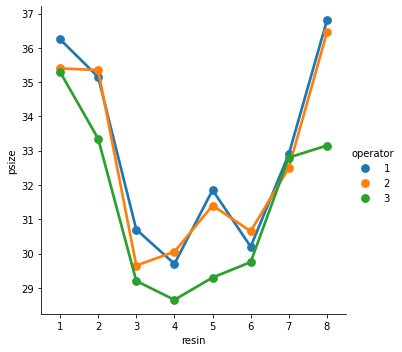

In [18]:
sns.catplot(x='resin',y='psize',hue='operator', data=pvc, kind="point",ci=None)

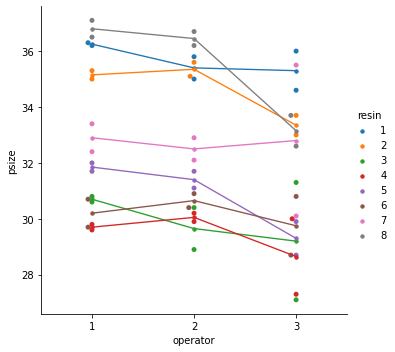

In [19]:
ax = sns.catplot(x='operator',y='psize',hue='resin', data=pvc, ci=None,scale=0.5,kind="point")
ax = sns.swarmplot(x='operator',y='psize',hue='resin', data=pvc)
ax.legend_.remove()

Create the ANOVA table

In [20]:
lmod = smf.ols('psize ~ operator*resin', pvc).fit()
sm.stats.anova_lm(lmod).round(3)

,df,sum_sq,mean_sq,F,PR(>F)
operator,2.0,20.718,10.359,7.007,0.004
resin,7.0,283.946,40.564,27.439,0.000
operator:resin,14.0,14.335,1.024,0.693,0.760
Residual,24.0,35.480,1.478,NaN,NaN


Now remove the interaction term:

In [21]:
lmod = smf.ols('psize ~ operator+resin', pvc).fit()
sm.stats.anova_lm(lmod).round(3)

,df,sum_sq,mean_sq,F,PR(>F)
operator,2.0,20.718,10.359,7.902,0.001
resin,7.0,283.946,40.564,30.943,0.000
Residual,38.0,49.815,1.311,NaN,NaN


Make the diagnostic plots:

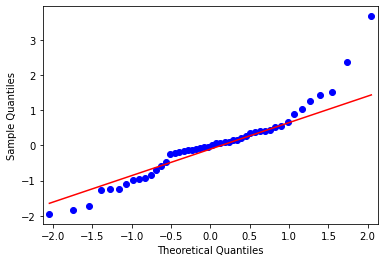

In [22]:
fig = sm.qqplot(lmod.resid, line="q")

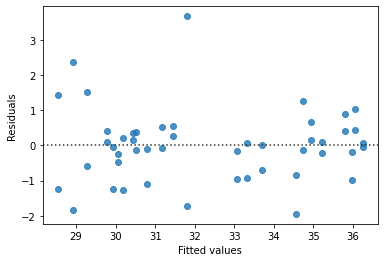

In [23]:
sns.residplot(lmod.fittedvalues, lmod.resid)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.show()

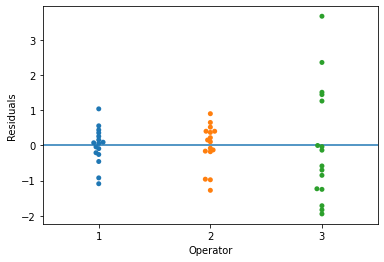

In [24]:
sns.swarmplot(pvc['operator'], lmod.resid)
plt.axhline(0)
plt.xlabel("Operator")
plt.ylabel("Residuals")
plt.show()

Test for equality of variance:

In [25]:
lmod = smf.ols('psize ~ operator*resin', pvc).fit()
ii = np.arange(0,48,2)
pvce = pvc.iloc[ii,:].copy()
pvce['res'] = np.sqrt(abs(lmod.resid.loc[ii+1]))
vmod = smf.ols('res ~ operator+resin', pvce).fit()
sm.stats.anova_lm(vmod,typ=3).round(3)

,sum_sq,df,F,PR(>F)
Intercept,0.263,1.0,5.326,0.037
operator,1.490,2.0,15.117,0.000
resin,0.638,7.0,1.848,0.155
Residual,0.690,14.0,NaN,NaN


In [26]:
lmod = smf.ols('psize ~ operator+resin', pvc).fit()
lmod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  psize   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     25.82
Date:                Tue, 23 Jun 2020   Prob (F-statistic):           1.47e-13
Time:                        17:12:28   Log-Likelihood:                -69.000
No. Observations:                  48   AIC:                             158.0
Df Residuals:                      38   BIC:                             176.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        36.2396      0.523     69.345      0.000      35.182      37.298
operator[T.2]    -0.2625      0.405     -0.648      0.521      -1.082       0.557
operator[T.3]    -1.5063      0.405     -3.721      0.001      -2.326      -0.687
resin[T.2]       -1.0333      0.661     -1.563      0.126      -2.372       0.305
resin[T.3]       -5.8000      0.661     -8.774      0.000      -7.138      -4.462
resin[T.4]       -6.1833      0.661     -9.354      0.000      -7.522      -4.845
resin[T.5]       -4.8000      0.661     -7.261      0.000      -6.138      -3.462
resin[T.6]       -5.4500      0.661     -8.245      0.000      -6.788      -4.112
resin[T.7]       -2.9167      0.661     -4.412      0.000      -4.255      -1.578
resin[T.8]       -0.1833      0.661     -0.277      0.783      -1.522       1.155
==============================================================================
Omnibus:                       13.065   Durbin-Watson:                   2.517
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.339
Skew:                           0.885   Prob(JB):                     0.000172
Kurtosis:                       5.353   Cond. No.                         9.82
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Get the Tukey critical value:

In [27]:
from statsmodels.sandbox.stats.multicomp import get_tukeyQcrit
get_tukeyQcrit(3,38)

array(3.45)

Get the first pairwise difference:

In [28]:
lmod.params[1] + np.array([-1,1]) * get_tukeyQcrit(3,38) * lmod.bse[1] / np.sqrt(2)

array([-1.25002748,  0.72502748])

# Two factors with an interaction

Read in the data:

In [29]:
warpbreaks = pd.read_csv("data/warpbreaks.csv", index_col=0, dtype={'breaks':'int','wool':'category','tension':'category'})
warpbreaks.head()

,breaks,wool,tension
1,26,A,L
2,30,A,L
3,54,A,L
4,25,A,L
5,70,A,L


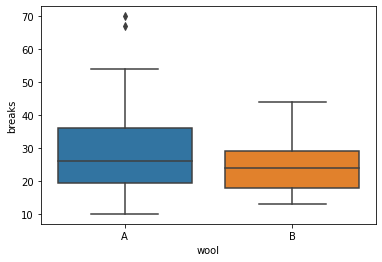

In [30]:
sns.boxplot(x="wool", y="breaks", data=warpbreaks)
plt.show()

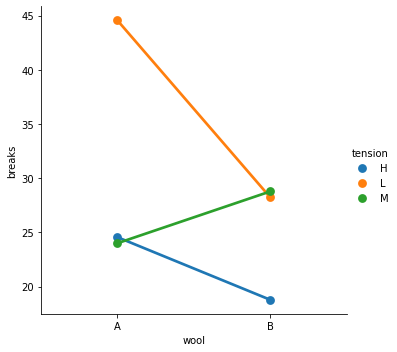

In [31]:
sns.catplot(x='wool',y='breaks',hue='tension', data=warpbreaks, ci=None,kind="point")

In [32]:
warpbreaks['nwool'] = warpbreaks['wool'].cat.codes

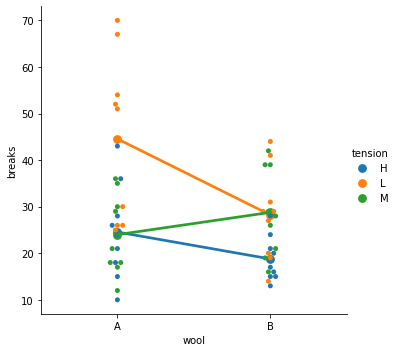

In [33]:
ax = sns.catplot(x='wool',y='breaks',hue='tension', data=warpbreaks, ci=None,kind="point")
ax = sns.swarmplot(x='wool',y='breaks',hue='tension', data=warpbreaks)
ax.legend_.remove()

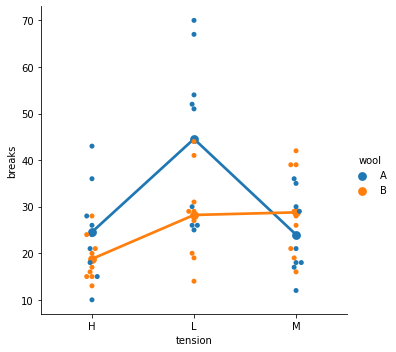

In [34]:
ax = sns.catplot(x='tension',y='breaks',hue='wool', data=warpbreaks, ci=None, kind="point")
ax = sns.swarmplot(x='tension',y='breaks',hue='wool', data=warpbreaks)
ax.legend_.remove()

Text(0, 0.5, 'Residuals')

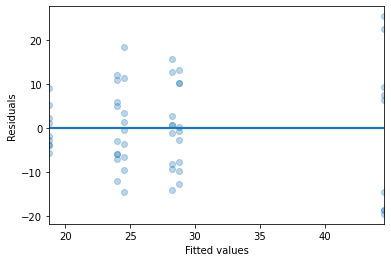

In [35]:
lmod = smf.ols('breaks ~ wool * tension', warpbreaks).fit()
sns.regplot(lmod.fittedvalues, lmod.resid,scatter_kws={'alpha':0.3}, ci=None)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")

Text(0, 0.5, 'Residuals')

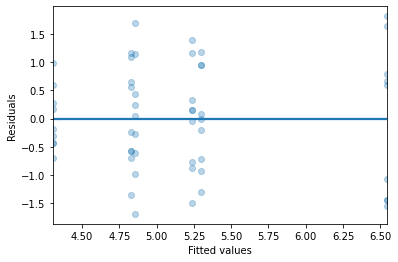

In [36]:
lmod = smf.ols('np.sqrt(breaks) ~ wool * tension', warpbreaks).fit()
sns.regplot(lmod.fittedvalues, lmod.resid,scatter_kws={'alpha':0.3}, ci=None)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")

In [37]:
sm.stats.anova_lm(lmod)

,df,sum_sq,mean_sq,F,PR(>F)
wool,1.0,2.901924,2.901924,3.022232,0.088542
tension,2.0,15.891615,7.945807,8.275225,0.000817
wool:tension,2.0,7.201396,3.600698,3.749976,0.030674
Residual,48.0,46.089229,0.960192,NaN,NaN


In [38]:
lmod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        np.sqrt(breaks)   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     5.415
Date:                Tue, 23 Jun 2020   Prob (F-statistic):           0.000500
Time:                        17:12:29   Log-Likelihood:                -72.346
No. Observations:                  54   AIC:                             156.7
Df Residuals:                      48   BIC:                             168.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  4.8564      0.327     14.868      0.000       4.200       5.513
wool[T.B]                 -0.5542      0.462     -1.200      0.236      -1.483       0.375
tension[T.L]               1.6912      0.462      3.661      0.001       0.762       2.620
tension[T.M]              -0.0304      0.462     -0.066      0.948      -0.959       0.898
wool[T.B]:tension[T.L]    -0.7553      0.653     -1.156      0.253      -2.069       0.558
wool[T.B]:tension[T.M]     1.0269      0.653      1.572      0.123      -0.287       2.340
==============================================================================
Omnibus:                        4.119   Durbin-Watson:                   2.147
Prob(Omnibus):                  0.127   Jarque-Bera (JB):                1.882
Skew:                           0.034   Prob(JB):                        0.390
Kurtosis:                       2.088   Cond. No.                         9.77
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
lmod = smf.ols('np.sqrt(breaks) ~ wool:tension-1', warpbreaks).fit()
lmod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        np.sqrt(breaks)   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     5.415
Date:                Tue, 23 Jun 2020   Prob (F-statistic):           0.000500
Time:                        17:12:29   Log-Likelihood:                -72.346
No. Observations:                  54   AIC:                             156.7
Df Residuals:                      48   BIC:                             168.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
wool[A]:tension[H]     4.8564      0.327     14.868      0.000       4.200       5.513
wool[B]:tension[H]     4.3022      0.327     13.171      0.000       3.645       4.959
wool[A]:tension[L]     6.5476      0.327     20.046      0.000       5.891       7.204
wool[B]:tension[L]     5.2381      0.327     16.037      0.000       4.581       5.895
wool[A]:tension[M]     4.8259      0.327     14.775      0.000       4.169       5.483
wool[B]:tension[M]     5.2987      0.327     16.222      0.000       4.642       5.955
==============================================================================
Omnibus:                        4.119   Durbin-Watson:                   2.147
Prob(Omnibus):                  0.127   Jarque-Bera (JB):                1.882
Skew:                           0.034   Prob(JB):                        0.390
Kurtosis:                       2.088   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Width of Tukey HSD bands is ( qt/sqrt(2) * se * sqrt(2))

In [40]:
get_tukeyQcrit(6,48) * lmod.bse[0]

1.3725048838137048

Compute all the pairwise differences:

In [41]:
import itertools
dp = set(itertools.combinations(range(0,6),2))
dcoef = []
namdiff = []
for cp in dp:
    dcoef.append(lmod.params[cp[0]] - lmod.params[cp[1]])
    namdiff.append(lmod.params.index[cp[0]] + '-' + lmod.params.index[cp[1]])
thsd = pd.DataFrame({'Difference':dcoef},index=namdiff)
thsd["lb"] = thsd.Difference - get_tukeyQcrit(6,48) * lmod.bse[0]
thsd["ub"] = thsd.Difference + get_tukeyQcrit(6,48) * lmod.bse[0]
thsd

,Difference,lb,ub
wool[A]:tension[H]-wool[B]:tension[H],0.554178,-0.818327,1.926683
wool[B]:tension[H]-wool[A]:tension[L],-2.245378,-3.617883,-0.872873
wool[B]:tension[H]-wool[B]:tension[L],-0.935944,-2.308449,0.436561
wool[A]:tension[M]-wool[B]:tension[M],-0.472707,-1.845212,0.899798
wool[B]:tension[H]-wool[A]:tension[M],-0.523746,-1.896251,0.848759
wool[B]:tension[H]-wool[B]:tension[M],-0.996453,-2.368958,0.376051
wool[A]:tension[L]-wool[A]:tension[M],1.721631,0.349127,3.094136
wool[A]:tension[H]-wool[B]:tension[M],-0.442276,-1.814781,0.930229
wool[A]:tension[L]-wool[B]:tension[L],1.309434,-0.063071,2.681939
wool[A]:tension[L]-wool[B]:tension[M],1.248924,-0.123580,2.621429


In [42]:
lmod.params.index

Index(['wool[A]:tension[H]', 'wool[B]:tension[H]', 'wool[A]:tension[L]',
       'wool[B]:tension[L]', 'wool[A]:tension[M]', 'wool[B]:tension[M]'],
      dtype='object')

# Larger factorial experiments

Read in the data

In [43]:
speedo = pd.read_csv("data/speedo.csv", index_col=0)
speedo

,h,d,l,b,j,f,n,a,i,e,m,c,k,g,o,y
1,-,-,+,-,+,+,-,-,+,+,-,+,-,-,+,0.4850
2,+,-,-,-,-,+,+,-,-,+,+,+,+,-,-,0.5750
3,-,+,-,-,+,-,+,-,+,-,+,+,-,+,-,0.0875
4,+,+,+,-,-,-,-,-,-,-,-,+,+,+,+,0.1750
5,-,-,+,+,-,-,+,-,+,+,-,-,+,+,-,0.1950
6,+,-,-,+,+,-,-,-,-,+,+,-,-,+,+,0.1450
7,-,+,-,+,-,+,-,-,+,-,+,-,+,-,+,0.2250
8,+,+,+,+,+,+,+,-,-,-,-,-,-,-,-,0.1750
9,-,-,+,-,+,+,-,+,-,-,+,-,+,+,-,0.1250
10,+,-,-,-,-,+,+,+,+,-,-,-,-,+,+,0.1200


In [44]:
%%capture --no-display
lmod = smf.ols('y ~ h+d+l+b+j+f+n+a+i+e+m+c+k+g+o', speedo).fit()
lmod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 23 Jun 2020   Prob (F-statistic):                nan
Time:                        17:12:29   Log-Likelihood:                 547.43
No. Observations:                  16   AIC:                            -1063.
Df Residuals:                       0   BIC:                            -1051.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5825        inf          0        nan         nan         nan
h[T.-]        -0.0622        inf         -0        nan         nan         nan
d[T.-]        -0.0609        inf         -0        nan         nan         nan
l[T.-]        -0.0272        inf         -0        nan         nan         nan
b[T.-]         0.0559        inf          0        nan         nan         nan
j[T.-]         0.0009        inf          0        nan         nan         nan
f[T.-]        -0.0741        inf         -0        nan         nan         nan
n[T.-]        -0.0066        inf         -0        nan         nan         nan
a[T.-]        -0.0678        inf         -0        nan         nan         nan
i[T.-]        -0.0428        inf         -0        nan         nan         nan
e[T.-]        -0.2453        inf         -0        nan         nan         nan
m[T.-]        -0.0278        inf         -0        nan         nan         nan
c[T.-]        -0.0897        inf         -0        nan         nan         nan
k[T.-]        -0.0684        inf         -0        nan         nan         nan
g[T.-]         0.1403        inf          0        nan         nan         nan
o[T.-]        -0.0059        inf         -0        nan         nan         nan
==============================================================================
Omnibus:                       17.995   Durbin-Watson:                   0.602
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.033
Skew:                          -1.744   Prob(JB):                     0.000121
Kurtosis:                       6.859   Cond. No.                         9.90
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Look at the design matrix:

In [45]:
dm = patsy.dmatrix('~ h+d+l+b+j+f+n+a+i+e+m+c+k+g+o', speedo)
np.asarray(dm)

array([[1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0.],
       [1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1.],
       [1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1.],
       [1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0.],
       [1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1.],
       [1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0.],
       [1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0.],
       [1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
       [1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0.],
       [1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1.,

Make a QQ plot of the coefficients:

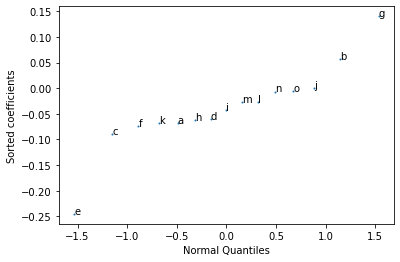

In [46]:
ii = np.argsort(lmod.params[1:])
scoef = np.array(lmod.params[1:])[ii]
lcoef = (speedo.columns[:-1])[ii]
n = len(scoef)
qq = stats.norm.ppf(np.arange(1,n+1)/(n+1))

fig, ax = plt.subplots()
ax.scatter(qq, scoef,s=1)

for i in range(len(qq)):
    ax.annotate(lcoef[i], (qq[i],scoef[i]))
    
plt.xlabel("Normal Quantiles")
plt.ylabel("Sorted coefficients")
plt.show()

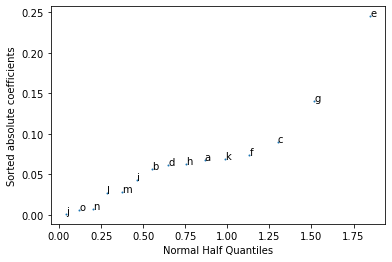

In [47]:
n = len(scoef)
qq = stats.norm.ppf((n + np.arange(1,n+1))/(2*n+1))
acoef = np.abs(lmod.params[1:])
ii = np.argsort(acoef)
acoef = acoef[ii]
lcoef = (speedo.columns[:-1])[ii]
                    
fig, ax = plt.subplots()
ax.scatter(qq, acoef,s=1)

for i in range(len(qq)):
    ax.annotate(lcoef[i], (qq[i],acoef[i]))
    
plt.xlabel("Normal Half Quantiles")
plt.ylabel("Sorted absolute coefficients")
plt.show()